<a href="https://colab.research.google.com/github/MamadouBousso/courspython/blob/develop/CNNDEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning avec Pytorch

Nous utilisons pytorch pour ce probleme

# CNN

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter5()
# This is needed to render the plots in this chapter
from plots.chapter5 import *

Finished!


In [ ]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep

# Convolutions

## Filter / Kernel

![](./images/conv1.png)

In [ ]:
single = np.array(
    [[[[5, 0, 8, 7, 8, 1],
       [1, 9, 5, 0, 7, 7],
       [6, 0, 2, 4, 6, 6],
       [9, 7, 6, 6, 8, 4],
       [8, 3, 8, 5, 1, 3],
       [7, 2, 7, 0, 1, 0]]]]
)
single.shape

(1, 1, 6, 6)

In [ ]:
identity = np.array(
    [[[[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]]]]
)
identity.shape

(1, 1, 3, 3)

## Convolving

![](./images/conv2.png)

In [ ]:
region = single[:, :, 0:3, 0:3]
filtered_region = region * identity
total = filtered_region.sum()
total

9

![](./images/conv3.png)

## Moving Around

![](./images/stride1.png)

In [ ]:
new_region = single[:, :, 0:3, (0+1):(3+1)]

![](./images/conv5.png)

In [ ]:
new_filtered_region = new_region * identity
new_total = new_filtered_region.sum()
new_total

5

![](./images/conv6.png)

![](./images/conv7.png)

In [ ]:
last_horizontal_region = single[:, :, 0:3, (0+4):(3+4)]

In [ ]:
#last_horizontal_region * identity

## Shape

![](./images/conv8.png)

$$
\Large
(h_i, w_i) * (h_f, w_f) = (h_i - (h_f - 1), w_i - (w_f - 1))
$$

$$
\Large
(h_i, w_i) * f = (h_i - f + 1, w_i - f + 1)
$$

## Convolving in PyTorch

In [ ]:
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

In [ ]:
convolved = F.conv2d(image, kernel_identity, stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

In [ ]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
conv(image)

tensor([[[[-3.6799, -0.6473, -1.4653, -2.0791],
          [ 2.9159, -0.1259,  0.5753,  0.2134],
          [-2.5582, -0.3535, -2.7864, -3.3930],
          [-3.2070, -3.7059, -3.1307, -3.1273]]]],
       grad_fn=<ConvolutionBackward0>)

In [ ]:
conv_multiple = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
conv_multiple.weight

Parameter containing:
tensor([[[[ 0.0118,  0.0860, -0.0598],
          [ 0.1702,  0.0301,  0.0247],
          [-0.0311, -0.0280,  0.1694]],

         [[-0.0495,  0.1782,  0.0108],
          [ 0.0893, -0.0120, -0.1066],
          [-0.0700, -0.0573,  0.0879]],

         [[-0.1206,  0.0806, -0.0377],
          [ 0.0026, -0.1224, -0.0566],
          [ 0.0025,  0.1574,  0.0438]]],


        [[[-0.1082,  0.0341, -0.1390],
          [ 0.0815, -0.0728, -0.1716],
          [-0.0752, -0.1068, -0.0256]],

         [[ 0.0323,  0.0037, -0.1304],
          [-0.1736,  0.1042,  0.1699],
          [ 0.0059, -0.1385, -0.0181]],

         [[-0.0695,  0.1308,  0.1882],
          [ 0.0985,  0.1065,  0.0456],
          [-0.0079, -0.0073,  0.1878]]],


        [[[ 0.1795, -0.1633, -0.1764],
          [ 0.0848,  0.0770,  0.1458],
          [ 0.1612,  0.1567, -0.0614]],

         [[ 0.0835, -0.1120, -0.1332],
          [-0.0363,  0.0484,  0.1420],
          [-0.1069, -0.1201, -0.1754]],

         [[ 0.0035,  0

In [ ]:
with torch.no_grad():
    conv.weight[0] = kernel_identity
    conv.bias[0] = 0

In [ ]:
conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

## Striding

![](./images/strider2.png)

![](./images/strider3.png)

$$
\Large
(h_i, w_i) * f = \left(\frac{h_i - f + 1}{s}, \frac{w_i - f + 1}{s}\right)
$$

In [ ]:
convolved_stride2 = F.conv2d(image, kernel_identity, stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

## Padding

![](./images/padding1.png)

In [ ]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [ ]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode='constant', value=0)

![](images/paddings.png)

In [ ]:
replication_padder = nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In [ ]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In [ ]:
F.pad(image, pad=(1, 1, 1, 1), mode='circular')

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

$$
\Large
(h_i, w_i) * f = \left(\frac{(h_i + 2p) - f + 1}{s}, \frac{(w_i + 2p) - f + 1}{s}\right)
$$

## A REAL Filter

In [ ]:
edge = np.array(
    [[[[0, 1, 0],
       [1, -4, 1],
       [0, 1, 0]]]]
)
kernel_edge = torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

![](./images/padding2.png)

![](./images/padding3.png)

In [ ]:
padded = F.pad(image, (1, 1, 1, 1), mode='constant', value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)

# Pooling

![](./images/pooling1.png)

In [ ]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [ ]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

In [ ]:
F.max_pool2d(conv_padded, kernel_size=3, stride=1)

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

# Flattening

In [ ]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [ ]:
pooled.view(1, -1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

# Typical Architecture

## LeNet5

![](images/architecture_lenet.png)

*Source: Generated using Alexander Lenail's [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author. For more details, see LeCun, Y., et al (1998).  [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Proceedings of the IEEE,86(11), 2278–2324*

In [ ]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func3', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

# A Multiclass Classification Problem

## Generation des données

Les données sont de trois classes:
* des images dont les motifs sont horizontaux
* des images dont les motifs sont verticaux
* des images dont les motifs sont obliques

In [ ]:
images, labels = generate_dataset(img_size=30, n_images=1000, binary=False, seed=17)

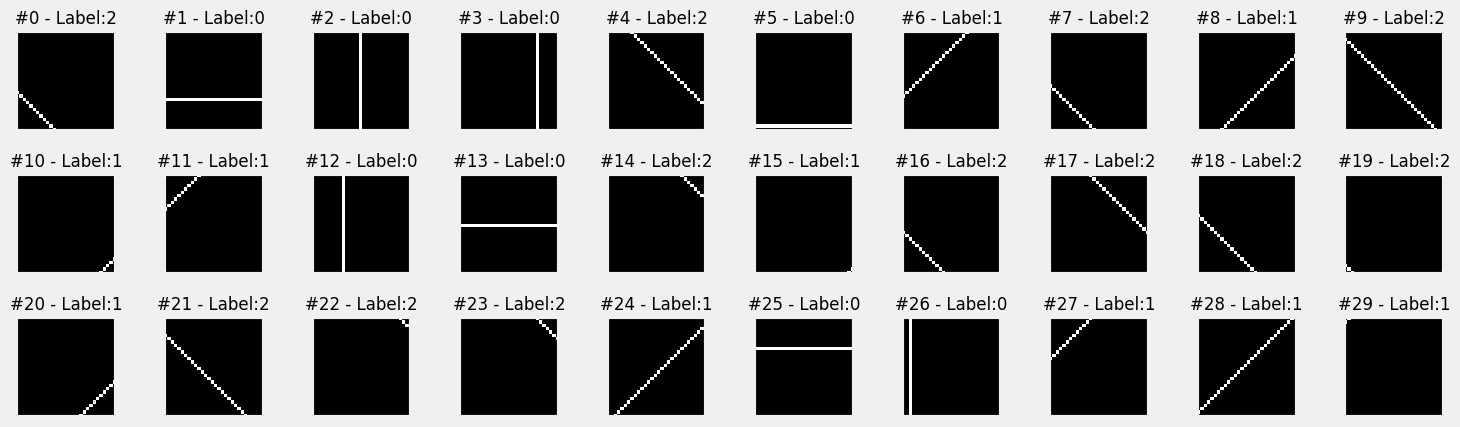

In [ ]:
fig = plot_images(images, labels, n_plot=30)

## Preparation des données

In [ ]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

In [ ]:

# Construire des tenseurs à partir de tableaux numpy avant le ecoupage
# Modifier l'echelle des pixels de [0, 255] à [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Utiliser index_splitter pour generer des indices pour les ensembles de training et de validation
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Utilser les  indices pour faire le decoupage
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Pas d'augmentation de données pour le moment
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Utiliser les ensembles de données personnalises pour appliquer les transformations
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)


# Construire un echantillonneur à poids aléatoire pour gerer le desequilibre des classes
sampler = make_balanced_sampler(y_train_tensor)


# Utiliser les echantillonneurs aléatoires dans l'ensemble de training pour charger les données de maniére equilibréee
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Loss

### Softmax

$$
\Large
\begin{array}
& z & = \text{logit}(p) & = \text{log odds ratio }(p) & = \text{log}\left(\frac{p}{1-p}\right)
\\
e^z & = e^{\text{logit}(p)} & = \text{odds ratio }(p) & = \left(\frac{p}{1-p}\right)
\end{array}
$$

$$
\Large
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{c=0}^{N_c-1}{e^{z_c}}}
$$

$$
\Large
\text{softmax}(z) = \left[\frac{e^{z_0}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_1}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_2}}{e^{z_0}+e^{z_1}+e^{z_2}}\right]
$$

In [ ]:
logits = torch.tensor([ 1.3863,  0.0000, -0.6931])

In [ ]:
odds_ratios = torch.exp(logits)
odds_ratios

tensor([4.0000, 1.0000, 0.5000])

In [ ]:
softmaxed = odds_ratios / odds_ratios.sum()
softmaxed

tensor([0.7273, 0.1818, 0.0909])

In [ ]:
nn.Softmax(dim=-1)(logits), F.softmax(logits, dim=-1)

(tensor([0.7273, 0.1818, 0.0909]), tensor([0.7273, 0.1818, 0.0909]))

### Negative Log Likelihood Loss

$$
\Large
\texttt{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
\\
\Large
\texttt{NLLLoss}(y)={-\frac{1}{(N_0+N_1+N_2)}\Bigg[{\sum_{i=1}^{N_0}{\text{log}(\text{P}(y_i=0))} + \sum_{i=1}^{N_1}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_2}{\text{log}(\text{P}(y_i=2))}}\Bigg]}
\\
\Large \texttt{NLLLoss}(y)={-\frac{1}{(N_0+\cdots+N_{C-1})}\sum_{c=0}^{C-1}{\sum_{i=1}^{N_c}{\text{log}(\text{P}(y_i=c))} }}
$$

In [ ]:
log_probs = F.log_softmax(logits, dim=-1)
log_probs

tensor([-0.3185, -1.7048, -2.3979])

In [ ]:
label = torch.tensor([2])
F.nll_loss(log_probs.view(-1, 3), label)

tensor(2.3979)

In [ ]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])
dummy_log_probs = F.log_softmax(dummy_logits, dim=-1)
dummy_log_probs

tensor([[-1.5229, -0.3146, -2.9600],
        [-1.7934, -1.0044, -0.7607],
        [-1.2513, -1.0136, -1.0471],
        [-2.6799, -0.2219, -2.0367],
        [-1.0728, -1.9098, -0.6737]])

In [ ]:
relevant_log_probs = torch.tensor([-1.5229, -1.7934, -1.0136, -2.0367, -1.9098])
-relevant_log_probs.mean()

tensor(1.6553)

In [ ]:
loss_fn = nn.NLLLoss()
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.6553)

In [ ]:
loss_fn = nn.NLLLoss(weight=torch.tensor([1., 1., 2.]))
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.7188)

In [ ]:
loss_fn = nn.NLLLoss(ignore_index=2)
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.5599)

In [ ]:
dummy_lots = torch.randn((5,3))
dummy_labs = torch.tensor([1, 0, 1, 2, 2])
dummy_preds = F.log_softmax(dummy_lots,dim=-1)
loss_f = nn.NLLLoss()
loss_f(dummy_preds,dummy_labs)

tensor(0.9289)

In [ ]:
loss_f2 = nn.CrossEntropyLoss()
loss_f2(dummy_preds, dummy_labs)

tensor(0.9289)

### Cross Entropy Loss

In [ ]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0,0,2,1,2])
print(dummy_labels.unsqueeze(dim=1).shape)
loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits, dummy_labels)

torch.Size([5, 1])


tensor(1.0518)

## Model Configuration

In [ ]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@30x30 -> n_channels_1@28x28 -> n_channels_1@14x14
n_channels_1 = 6
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels_1, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))

# Block 1: n_channels1@14x14 -> n_channels_2@12x12 -> n_channels_2@6x6
n_channels_2 = 12
model_cnn1.add_module('conv2', nn.Conv2d(in_channels=n_channels_1, out_channels=n_channels_2, kernel_size=3))
model_cnn1.add_module('relu2', nn.ReLU())
model_cnn1.add_module('maxp2', nn.MaxPool2d(kernel_size=2))

# Flattening: n_channels_2 * 6 * 6
model_cnn1.add_module('flatten', nn.Flatten())

In [ ]:
# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels_2*6*6, out_features=10))
model_cnn1.add_module('relu3', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc3', nn.Linear(in_features=10, out_features=3))

![](images/classification_softmax.png)

In [ ]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

## Model Training

In [ ]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)

In [ ]:
sbs_cnn1.train(20)

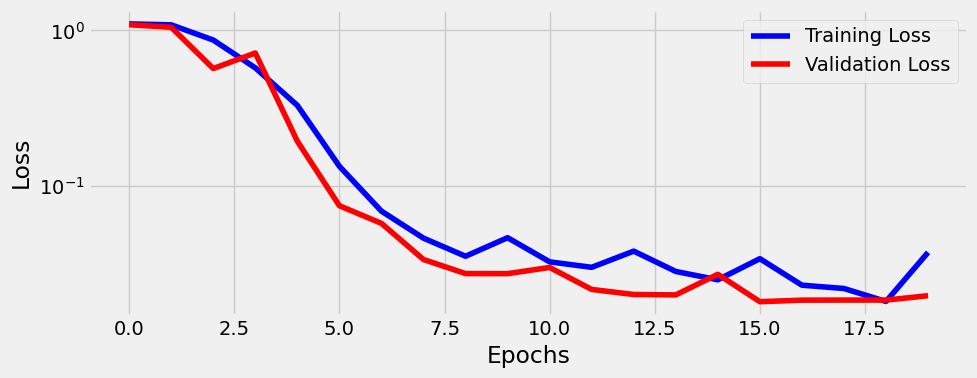

In [ ]:
fig = sbs_cnn1.plot_losses()

## Visualisation des filtres!

Nous allons visualiser les poids comme des pixels et les filtres comme des images. Pour cela nous allons utiliser la fonction ci-dessous qui prend en entrée les argumants suivants:
* axs: tableau de graphes correspondant à une ligne de sous-graphes retournée par matplotlib
* x: un tableau Numpy contenant au moins autant d'images ou de filtres que le sous-graphe de axs
* y: un tableau optionnel contenant au moins autant de labels que les sous-graphes de axs
* yhat: un tableau optionnel contenant au moins autant de prediction que les sous-graphes de axs
* layer_name: label d'une ligne du sous-graph
* title: prefixe pour chaque sous-graphe

La methode est decorée comme static, cela veut dire qu'il peut  etre appelée avec le nom de la classe. Il n'a pas pas de parametre self.

On peut utiliser cette methode pour visualiser les images qui nous interessent.

In [ ]:
@staticmethod
def _visualize_tensors(axs, x, y=None, yhat=None,
                       layer_name='', title=None):
    # Le nombre d'images est le nombre de sous-graphe dans une ligne
    n_images = len(axs)
    # Gets max and min values for scaling the grayscale
    # Obtenir les valeurs max et min pour pour faire correspondre les echelles en niveaux de gris
    minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
    # Pour chaque image
    for j, image in enumerate(x[:n_images]):
        ax = axs[j]
        # Sets title, labels, and removes ticks
        # Mettre titre, labels, et enlever les graduations
        if title is not None:
            ax.set_title(f'{title} #{j}', fontsize=12)
        shp = np.atleast_2d(image).shape
        ax.set_ylabel(
            f'{layer_name}\n{shp[0]}x{shp[1]}',
            rotation=0, labelpad=40
        )
        xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
        xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
        xlabel = f'{xlabel1}{xlabel2}'
        if len(xlabel):
            ax.set_xlabel(xlabel, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        # Afficher les poids comme une image
        ax.imshow(
            np.atleast_2d(image.squeeze()),
            cmap='gray',
            vmin=minv,
            vmax=maxv
        )
    return

setattr(StepByStep, '_visualize_tensors', _visualize_tensors)

###  Methode Static

In [ ]:
class Cat(object):
    def __init__(self, name):
        self.name = name

    @staticmethod
    def meow():
        print('Meow')

In [ ]:
Cat.meow()

Meow


### Visualiser les  Filtres
Nous pouvons visualiser tous les filtres que le modele a concus à travers les differentes entrainements sous forme d'images .
* Dans la premmiére couche convolée nous aurons un canal d'entrée et 6 filtres
* Dans la deuxieme couche convolée nous aurons 6 canaux d'entrée et 12 filtres par canal

On peut recuperer tous ces filtres en utilisant la commande ci-dessous.


In [ ]:
weights_filter_couche1 = model_cnn1.conv1.weight.data.cpu().numpy()
weights_filter_couche1.shape

(6, 1, 3, 3)

In [ ]:
weights_filter_couche2 = model_cnn1.conv2.weight.data.cpu().numpy()
weights_filter_couche2.shape

(12, 6, 3, 3)

Chaque couche de convolution a son weight. Nous avons visualiser les dimensions de celle de la couche "conv1".
Nous avons six filtres et un canal. Nous ne voulons que les données donc nous les detachons du graphe de calcul et les presentons sous forme de tableau numpy. Dans les dimensions la premiére dimension est celle des filtres et la deuxieme represente les canaux.

Nous pouvons utiliser la fonction definie ci-dessus pour les visualiser.

Quelques astuces python utilises dans ce code: le metaprogramming

In [ ]:
def visualize_filters(self, layer_name, **kwargs):
    try:

        # Recuperer l'objet layer du modele
        layer = self.model
        for name in layer_name.split('.'):
            layer = getattr(layer, name)
        # Nous cherchons seulement des filtres pour une convolution 2D
        if isinstance(layer, nn.Conv2d):
            # Recuperer  les infos sur les poids
            weights = layer.weight.data.cpu().numpy()
            # poids -> (canaux_out (filtre), canaux_in, H, W)
            n_filters, n_channels, _, _ = weights.shape

            # Construire une figure
            size = (2 * n_channels + 2, 2 * n_filters)
            fig, axes = plt.subplots(n_filters, n_channels,
                                     figsize=size)
            axes = np.atleast_2d(axes)
            axes = axes.reshape(n_filters, n_channels)
            # Pour chaque canal_out (filtre)
            for i in range(n_filters):
                StepByStep._visualize_tensors(
                    axes[i, :],
                    weights[i],
                    layer_name=f'Filtre #{i}',
                    title='Canal'
                )

            for ax in axes.flat:
                ax.label_outer()

            fig.tight_layout()
            return fig
    except AttributeError:
        return

setattr(StepByStep, 'visualize_filters', visualize_filters)

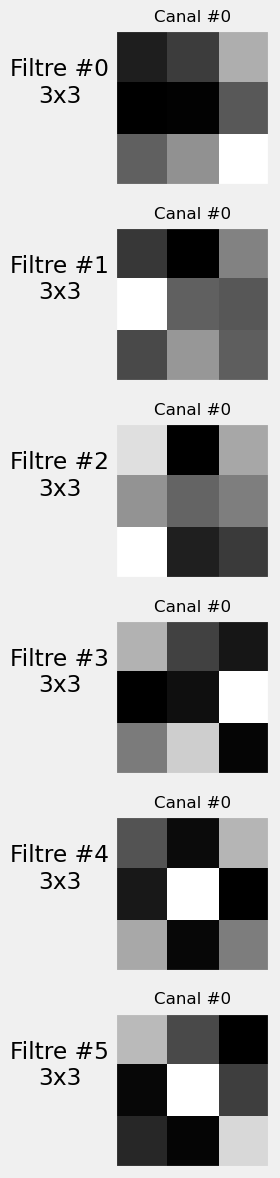

In [ ]:
fig = sbs_cnn1.visualize_filters('conv1', cmap='gray')

* Chaque ligne coreespond à un filtre et les images dans la ligne correspondent.

* Le modele apprend differents poids à convoler avec les données d'un des canaux d'entrées

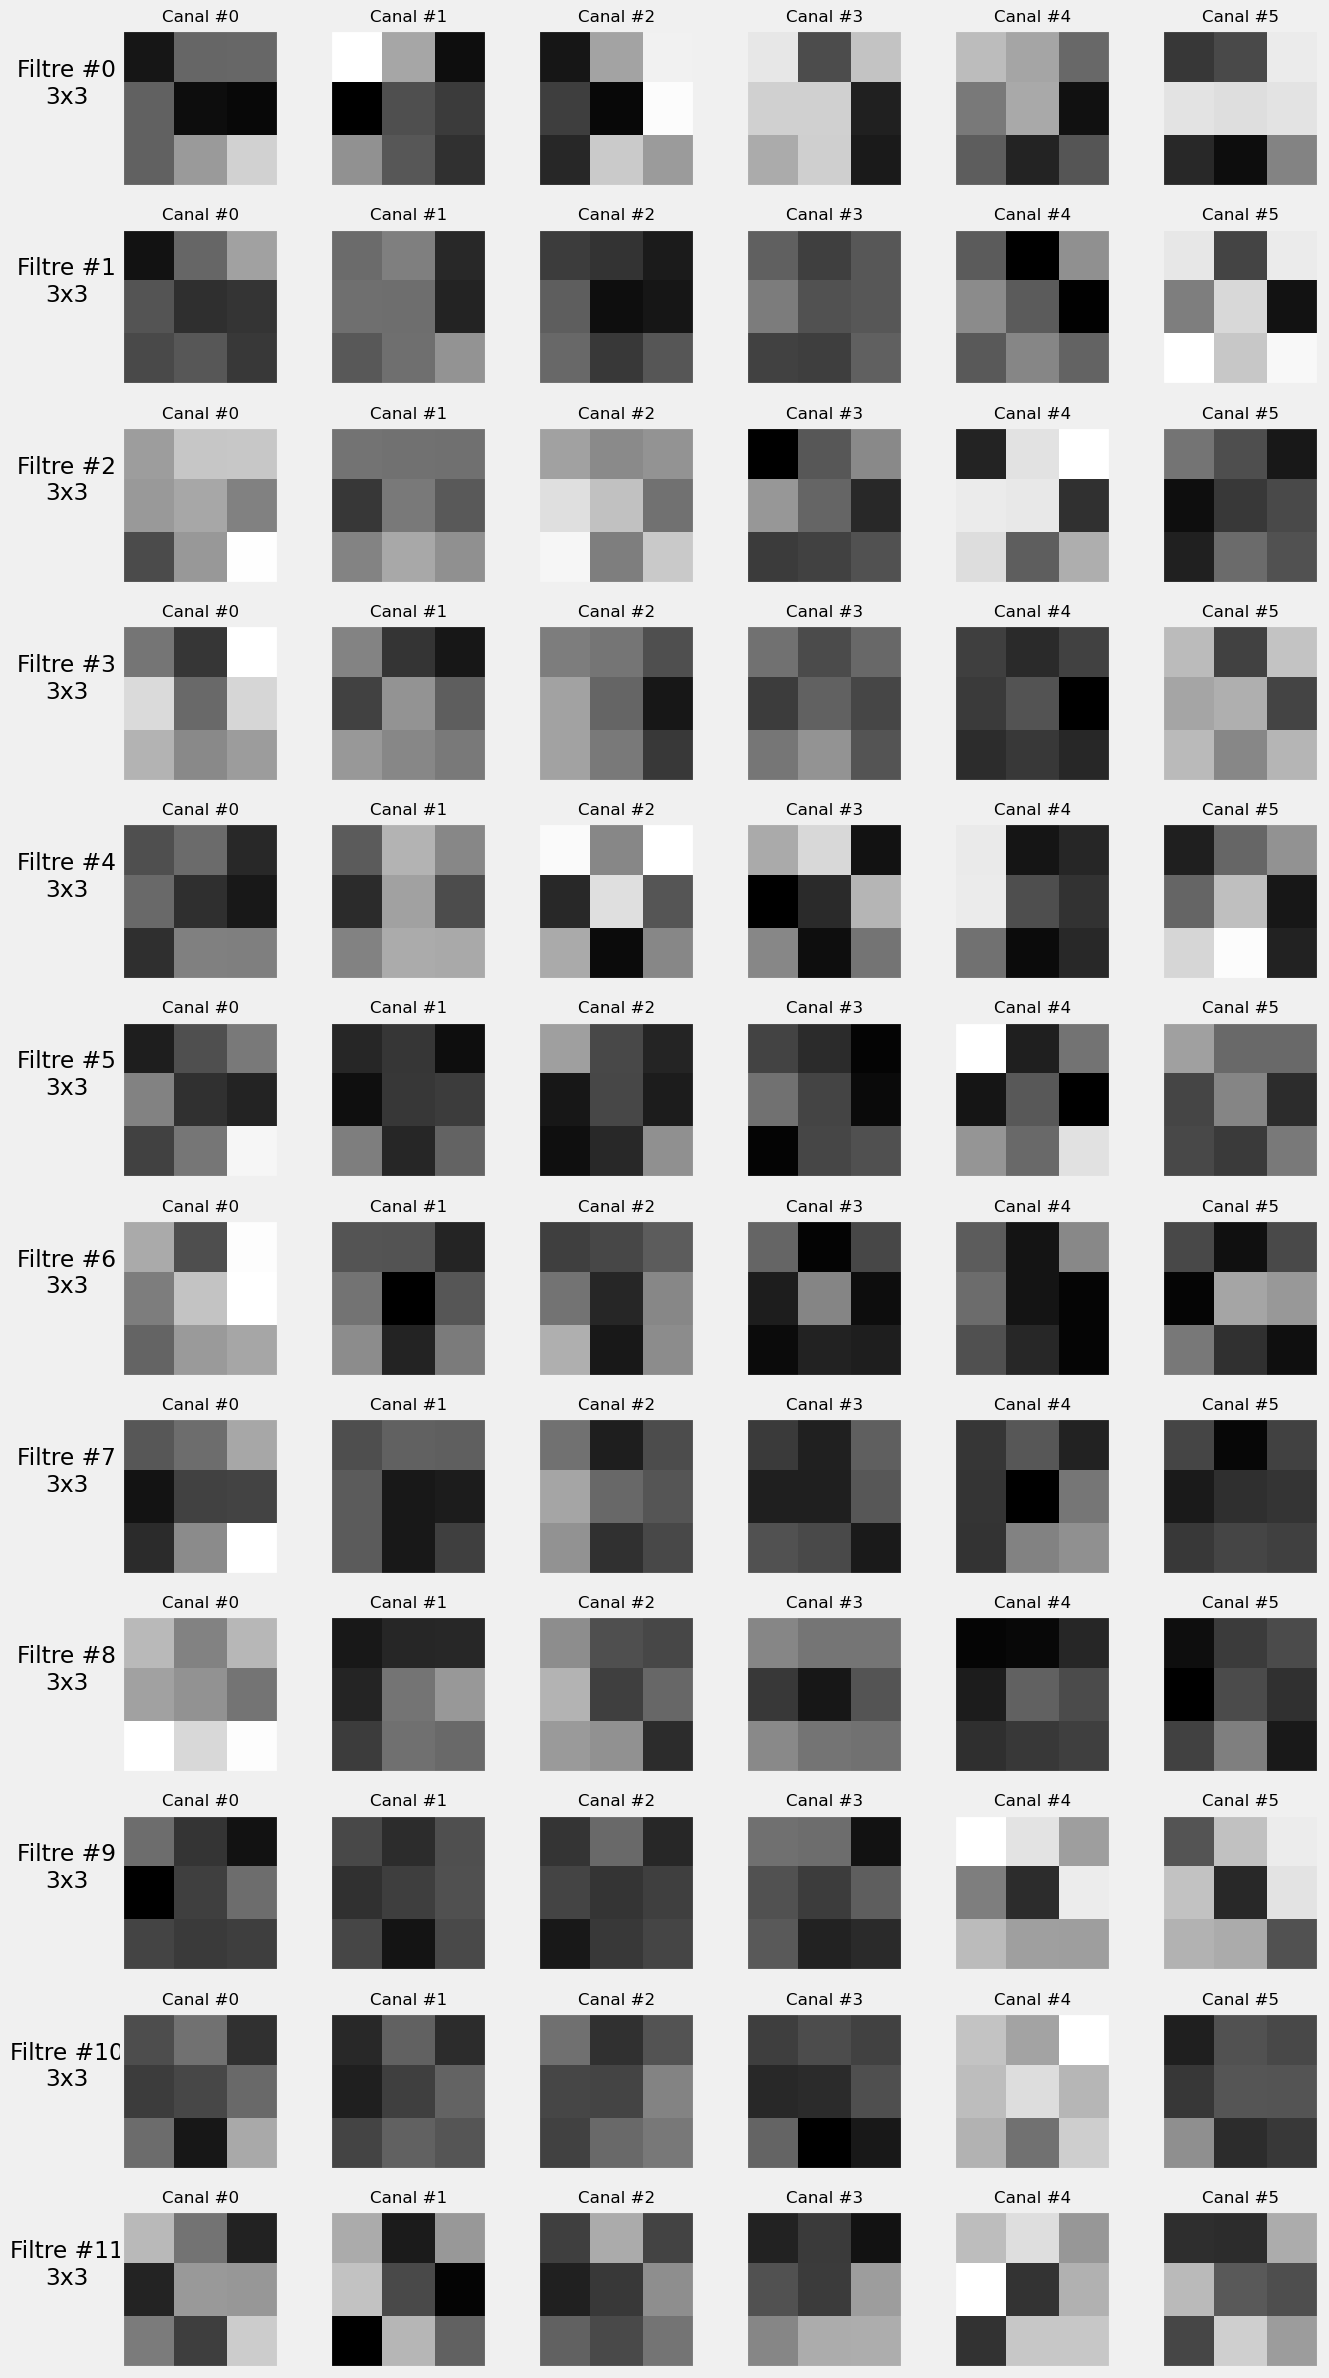

In [ ]:
fig1 = sbs_cnn1.visualize_filters('conv2', cmap='gray')

On a ces filtres mais ils ne nous renseigent pas sur leurs effets sur les données. Pour comprendre ces effets il nous faut visualiser les valeurs intermediaires produites par le modele: les outputs de chaque couche.

### Hooks

Ils permettent d'executer une fonction avant ou aprés un forward ou un backward. Il y a donc des hooks pour forward et des hooks pour backward mais les principes restent les memes.

Dans le cas du forward la fonction hook prend 3 arguments:

* Un modele ou une couche

* Un tenseur representant les inputs du modele ou de la couche

* Un tenseur representant les outputs du modele ou de la couche


Ainsi toute fonction ayant ces 3 arguments peut etre utilisées comme fonction hook.

#### Exemple 1

In [ ]:
# Mon modele
dummy_mod = nn.Linear(2,2)
# Une liste pour mettre des données generees avec le hook
dummy_l = []
# La fonction de hook qui met dans une liste la couche, les inputs et outputs de la couche

def funct_hook(layer, inputs,outputs):
    dummy_l.append((layer,inputs,outputs))

* On utilise une variable independante pour stocker les données de la fonction hook. C'est le cas de dummy_l
* La fonction register_forward_hook(funct_hook) retourne un objet qui permet de tracker les hook attaches au modele

In [ ]:
dummy_h = dummy_mod.register_forward_hook(funct_hook)

In [ ]:
dummy_h

In [ ]:
dummy_z = torch.tensor([0.3,0.6])
dummy_mod.forward(dummy_z)

tensor([ 1.0623, -0.6189], grad_fn=<AddBackward0>)

In [ ]:
dummy_l

[]

L'appel à la methode forward directement ne donne rien. Il faut faire appel au modele

In [ ]:
dummy_mod(dummy_z)

tensor([ 1.0623, -0.6189], grad_fn=<AddBackward0>)

In [ ]:
dummy_l

[(Linear(in_features=2, out_features=2, bias=True),
  (tensor([0.3000, 0.6000]),),
  tensor([ 1.0623, -0.6189], grad_fn=<AddBackward0>))]

In [ ]:
dummy_model = nn.Linear(1, 1)

dummy_list = []

def dummy_hook(layer, inputs, outputs):
    dummy_list.append((layer, inputs, outputs))

In [ ]:
dummy_handle = dummy_model.register_forward_hook(dummy_hook)
dummy_handle

In [ ]:
dummy_x = torch.tensor([0.3])

dummy_model.forward(dummy_x)

tensor([-1.0739], grad_fn=<AddBackward0>)

In [ ]:
dummy_list

[]

L'appel à la methode forward directement ne donne rien. Il faut faire appel au modele

In [ ]:
dummy_model(dummy_x)

tensor([-1.0739], grad_fn=<AddBackward0>)

In [ ]:
dummy_list

[(Linear(in_features=1, out_features=1, bias=True),
  (tensor([0.3000]),),
  tensor([-1.0739], grad_fn=<AddBackward0>))]

In [ ]:
dummy_h.remove()

#### Exemple avec notre modele

In [ ]:
# Listons les modules associes à notre modele
modules = list(sbs_cnn1.model.named_modules())
modules

[('',
  Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
    (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=432, out_features=10, bias=True)
    (relu3): ReLU()
    (fc3): Linear(in_features=10, out_features=3, bias=True)
  )),
 ('conv1', Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))),
 ('relu1', ReLU()),
 ('maxp1',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('conv2', Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))),
 ('relu2', ReLU()),
 ('maxp2',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('flatten', Flatten(start_dim=1, end_dim=-1)),
 ('fc1', Linear(in_features=432, out_features=10, bi

In [ ]:
# Ecrivons les couches sous forme de dictionnaire
layer_names = {layer: name for name, layer in modules[1:]}
layer_names

{Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1)): 'conv1',
 ReLU(): 'relu1',
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): 'maxp1',
 Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1)): 'conv2',
 ReLU(): 'relu2',
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): 'maxp2',
 Flatten(start_dim=1, end_dim=-1): 'flatten',
 Linear(in_features=432, out_features=10, bias=True): 'fc1',
 ReLU(): 'relu3',
 Linear(in_features=10, out_features=3, bias=True): 'fc3'}

In [ ]:
# Ecrivons la fonction hook en utilisant un dictionnaire defini hors de la fonction. Le nom de chaque couche est
# est une cle. Les inputs sont ignores
visualization = {}

def hook_fn(layer, inputs, outputs):
    name = layer_names[layer]
    visualization[name] = outputs.detach().cpu().numpy()

In [ ]:
# Nous constituons une liste de couches pour lesquelles nous voulons les outputs. Nous iterons sur cette liste
# enregistrons notre fonction de hook pour cette couche.On tracke les objets qui nous interessent pour chaque couche
# à l'aide d'un autre dictionnaire
layers_to_hook = ['conv1', 'relu1', 'maxp1','conv2', 'relu2', 'maxp2', 'flatten', 'fc1', 'relu3', 'fc3']

handles = {}

for name, layer in modules:
    if name in layers_to_hook:
        handles[name] = layer.register_forward_hook(hook_fn)

In [ ]:
# Nous testons avec une prediction sur un mini-batch ou le modele sera appele. Il y aura un forward
images_batch, labels_batch = next(iter(val_loader))
logits = sbs_cnn1.predict(images_batch)

In [ ]:
# On visualise les cles du dictionnaire contenant les outputs
visualization.keys()

dict_keys(['conv1', 'relu1', 'maxp1', 'conv2', 'relu2', 'maxp2', 'flatten', 'fc1', 'relu3', 'fc3'])

In [ ]:
# Supprimons les handles qui traquent les objets pour ne pas ralentir notre modele
for handle in handles.values():
    handle.remove()
handles = {}

##### Visualisons les outputs

In [ ]:
setattr(StepByStep, 'visualization', {})
setattr(StepByStep, 'handles', {})

def attach_hooks(self, layers_to_hook, hook_fn=None):
    # Nettoie les valeurs passees
    self.visualization = {}

    # Cree un dictionnaire qui fait un mapping entre les couches et leurs noms
    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules[1:]}

    if hook_fn is None:
        # fonction hook attaché au forward
        def hook_fn(layer, inputs, outputs):
            # Recuperer les noms des couches
            name = layer_names[layer]
            # Detacher du graphe de calcul les outputs et les retourner sous forme de tableau numpy
            values = outputs.detach().cpu().numpy()
            # La fonction hook peut etre appelee plusieurs fois
            # par exemple des predictions pour plusieurs mini-batch
            # il concatene les resultats
            if self.visualization[name] is None:
                self.visualization[name] = values
            else:
                self.visualization[name] = np.concatenate([self.visualization[name], values])

    for name, layer in modules:
        # Si la couche est dans notre liste
        if name in layers_to_hook:
            # Initialise la cle correspondante dans le dictionnaire
            self.visualization[name] = None
            # Cree le forward hook et utilise un autre dictionnaire pour traquer les objets
            self.handles[name] = layer.register_forward_hook(hook_fn)

def remove_hooks(self):
    # Itere sur l'ensemble des hook et les supprime
    for handle in self.handles.values():
        handle.remove()
    # Nettoie le dictionnaire
    self.handles = {}

setattr(StepByStep, 'attach_hooks', attach_hooks)
setattr(StepByStep, 'remove_hooks', remove_hooks)

In [ ]:
sbs_cnn1.attach_hooks(layers_to_hook=['conv1', 'relu1', 'maxp1','conv2', 'relu2', 'maxp2' 'flatten', 'fc1', 'relu3', 'fc3'])

In [ ]:
 # Le modele est appele
images_batch, labels_batch = iter(val_loader).next()
logits = sbs_cnn1.predict(images_batch)

In [ ]:
 # Nettoyage du dictionnaire
sbs_cnn1.remove_hooks()

In [ ]:
predicted = np.argmax(logits, 1)
predicted

array([0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2], dtype=int64)

### Visualisation des caracteristiques
Les premieres couches du reseau que sont: 'conv1', 'relu1', 'maxp1','conv2', 'relu2', 'maxp2' 'flatten' sont appeles features et de representer les caracteristiques du modele. La methode ci-dessous permettra de les visualiser

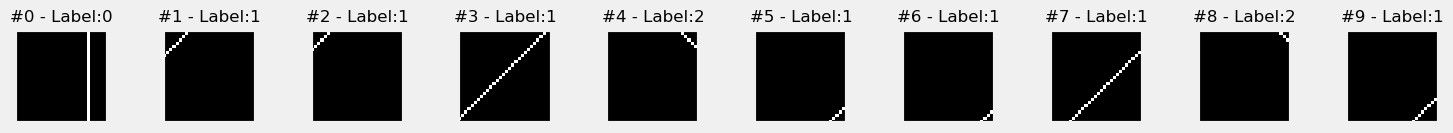

In [ ]:
fig = plot_images(images_batch.squeeze(), labels_batch.squeeze(), n_plot=10)

In [ ]:
def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
    layers = filter(lambda l: l in self.visualization.keys(), layers)
    layers = list(layers)
    shapes = [self.visualization[layer].shape for layer in layers]
    n_rows = [shape[1] if len(shape) == 4 else 1
              for shape in shapes]
    total_rows = np.sum(n_rows)

    fig, axes = plt.subplots(total_rows, n_images,
                             figsize=(1.5*n_images, 1.5*total_rows))
    axes = np.atleast_2d(axes).reshape(total_rows, n_images)

    # Boucles sur les couches, une couche par ligne de sous-graphe
    row = 0
    for i, layer in enumerate(layers):
        start_row = row
        # Recupere le sous-graphe produit
        output = self.visualization[layer]

        is_vector = len(output.shape) == 2

        for j in range(n_rows[i]):
            StepByStep._visualize_tensors(
                axes[row, :],
                output if is_vector else output[:, j].squeeze(),
                y,
                yhat,
                layer_name=layers[i] \
                           if is_vector \
                           else f'{layers[i]}\nfil#{row-start_row}',
                title='Image' if (row == 0) else None
            )
            row += 1

    for ax in axes.flat:
        ax.label_outer()

    plt.tight_layout()
    return fig

setattr(StepByStep, 'visualize_outputs', visualize_outputs)

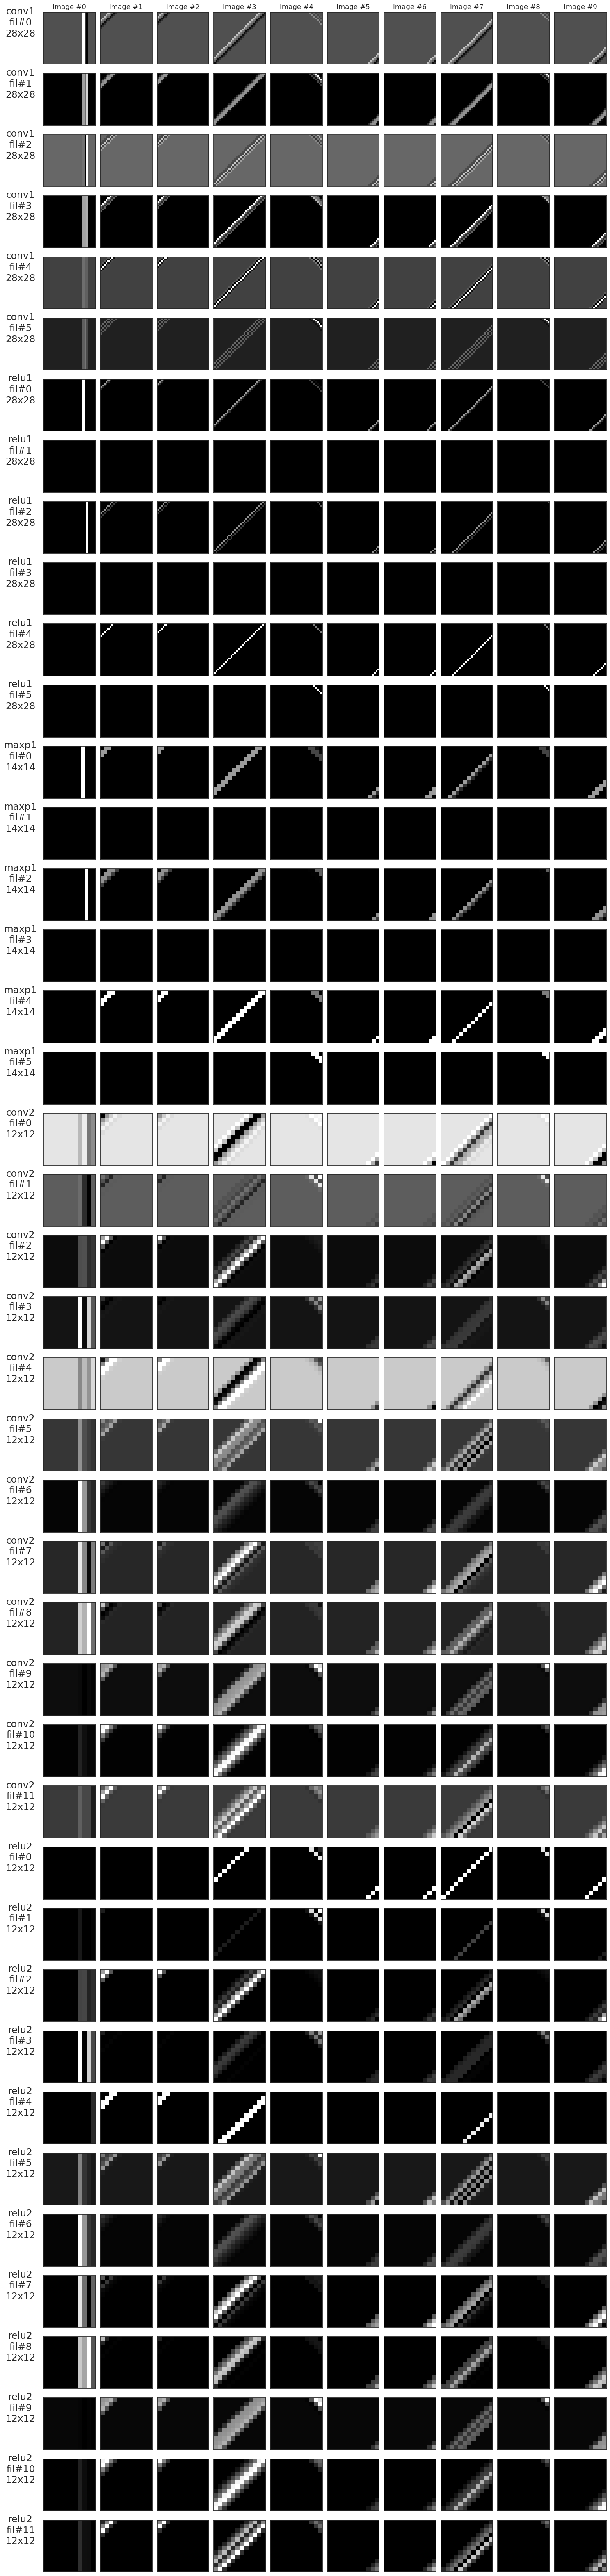

In [ ]:
featurizer_layers = ['conv1', 'relu1', 'maxp1','conv2', 'relu2', 'maxp2' 'flatten']

with plt.style.context('seaborn-white'):
    fig = sbs_cnn1.visualize_outputs(featurizer_layers)

Exercice: Interpreter les resultats observes

### Visualisation de la deuxieme partie appelée Classifier

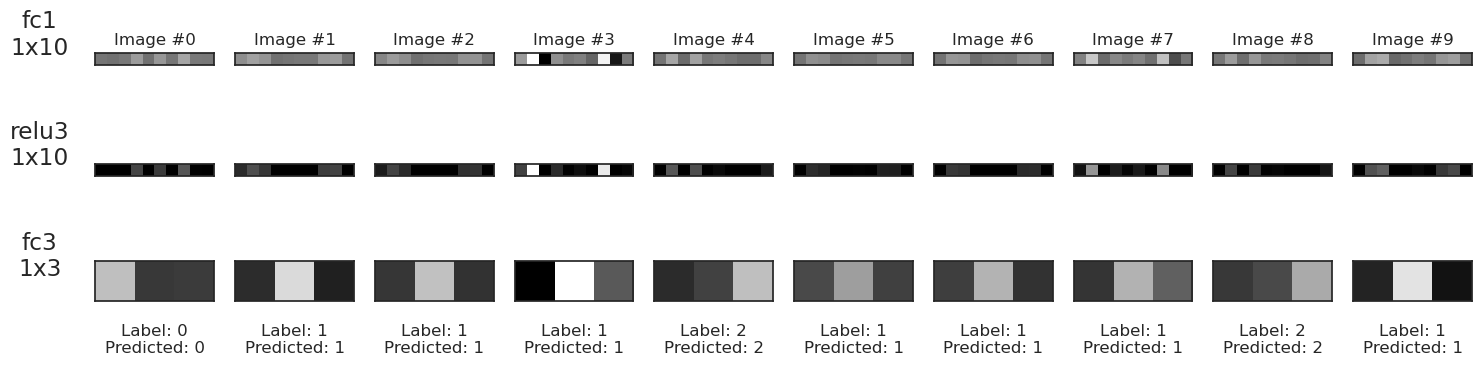

In [ ]:
classifier_layers = ['flatten','fc1', 'relu3', 'fc3']

with plt.style.context('seaborn-white'):
    fig = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

La couche fc1 effectue une transformation affine avec une reduction des dimension. La couche ReLU elimine les valeurs negatives.
La derniére couche transforme les dimensions en 3 logits et le plus brillant correspond à la prediction. Toutes les predictions sont correctes.



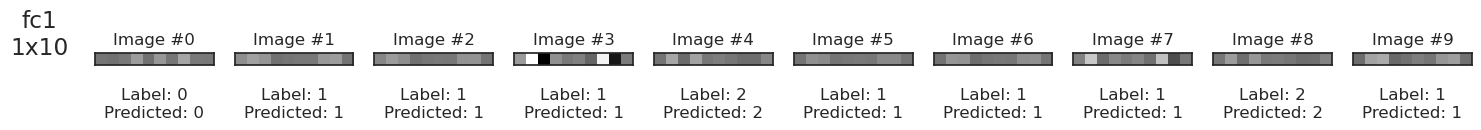

In [ ]:
classifier_layers = ['flatten','fc1']

with plt.style.context('seaborn-white'):
    fig = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

Calculons l'accuracy

### Accuracy

In [ ]:
def correct(self, x, y, threshold=.5):
    self.model.eval()
    yhat = self.model(x.to(self.device))
    y = y.to(self.device)
    self.model.train()

    # Nous recuperons la taille du batche et le nombre de classes
    # (seulement  une classe si on est dans du binaire)
    n_samples, n_dims = yhat.shape
    if n_dims > 1:
        # Dans une classification multiclass classification, le loggit le plus elevé
        #l'emporte toujours donc pas besoin de calculer des probabilites

        # La version d'argmax de pytorch
        # mais il retourne un tuple: (valeur du max, index de la valeur maximale)
        _, predicted = torch.max(yhat, 1)
    else:
        n_dims += 1
        # En classification binaire, nous avons besoin de verifier
        # si la derniere couche est un sigmoid et alors il produit des  probs
        if isinstance(self.model, nn.Sequential) and \
           isinstance(self.model[-1], nn.Sigmoid):
            predicted = (yhat > threshold).long()
        # ou quelque chose d'autre (comme des logits), alors nous les convertissons
        # en probabilités en utilisant un sigmoid
        else:
            predicted = (F.sigmoid(yhat) > threshold).long()

    # Combien d'echantillon sont correctement classifie pour chaque classe
    result = []
    for c in range(n_dims):
        n_class = (y == c).sum().item()
        n_correct = (predicted[y == c] == c).sum().item()
        result.append((n_correct, n_class))
    return torch.tensor(result)

setattr(StepByStep, 'correct', correct)

In [ ]:
sbs_cnn1.correct(images_batch, labels_batch)

tensor([[ 2,  2],
        [10, 10],
        [ 4,  4]])

Ce resultat a été calcule poour un seul mini-batch. Calculons le pour tous les batch

### Utilisons la fonction loader_apply
Appliquons la fonction ci-dessous à chaque mini-batch, empilons les resultats et appliquons une fonction de reduction telle que mean ou sum

In [ ]:
@staticmethod
def loader_apply(loader, func, reduce='sum'):
    results = [func(x, y) for i, (x, y) in enumerate(loader)]
    results = torch.stack(results, axis=0)

    if reduce == 'sum':
        results = results.sum(axis=0)
    elif reduce == 'mean':
        results = results.float().mean(axis=0)

    return results

setattr(StepByStep, 'loader_apply', loader_apply)

In [ ]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)

tensor([[54, 54],
        [83, 84],
        [62, 62]])

## Mettons tout ensemble

### Preparation des données

In [ ]:
# Construire des tenseurs à partir de tableaux numpy avant le ecoupage
# Modifier l'echelle des pixels de [0, 255] à [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Utiliser index_splitter pour generer des indices pour les ensembles de training et de validation
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Utilser les  indices pour faire le decoupage
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Pas d'augmentation de données pour le moment
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Utiliser les ensembles de données personnalises pour appliquer les transformations
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)


# Construire un echantillonneur à poids aléatoire pour gerer le desequilibre des classes
sampler = make_balanced_sampler(y_train_tensor)


# Utiliser les echantillonneurs aléatoires dans l'ensemble de training pour charger les données de maniére equilibréee
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Configuration du  modele

In [ ]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Definition des couches de convolution
# Bloc 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Aplattissement: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

# Classification
# Couche cachee
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Couche de sortie
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

### Training du modele

In [ ]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)
sbs_cnn1.train(20)

### Visualisation des  filtres

In [ ]:
fig_filters = sbs_cnn1.visualize_filters('conv1', cmap='gray')

### Capturer les sorties

In [ ]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

sbs_cnn1.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

images_batch, labels_batch = iter(val_loader).next()
logits = sbs_cnn1.predict(images_batch)
predicted = np.argmax(logits, 1)

sbs_cnn1.remove_hooks()

### Visualiser les images de sorties par couches

In [ ]:
with plt.style.context('seaborn-white'):
    fig_maps1 = sbs_cnn1.visualize_outputs(featurizer_layers)
    fig_maps2 = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

### Accuracy

In [ ]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)